In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tifffile as tiff
from tqdm import tqdm

!pip install tifffile -q
!pip install efficientnet -q
import efficientnet.tfkeras as efn


IMAGE_ROOT = '/kaggle/input/water-segmentation-images/images-20250919T154810Z-1-001/images'
MASK_ROOT = '/kaggle/input/water-segmentation-masks/labels-20250919T154815Z-1-001/labels'

In [4]:
print("Images folder contents (sample 10):", sorted(os.listdir(IMAGE_ROOT))[:10])
print("Masks folder contents (sample 10):", sorted(os.listdir(MASK_ROOT))[:10])


Images folder contents (sample 10): ['0.tif', '1.tif', '10.tif', '100.tif', '101.tif', '102.tif', '103.tif', '104.tif', '105.tif', '106.tif']
Masks folder contents (sample 10): ['0.png', '1.png', '10.png', '100.png', '100_184.png', '101.png', '101_89.png', '102.png', '102_179.png', '103.png']


In [11]:
def base_id_from_image(path):
    return os.path.splitext(os.path.basename(path))[0]

def base_id_from_mask(path):
    name = os.path.splitext(os.path.basename(path))[0]
    parts = name.split('_')
    return parts[0]

image_paths = sorted(glob(os.path.join(IMAGE_ROOT, '*.tif')))
mask_paths = sorted(glob(os.path.join(MASK_ROOT, '*.png')) + glob(os.path.join(MASK_ROOT, '*.tif')))

mask_map = {}
for m in mask_paths:
    bid = base_id_from_mask(m)
    if bid not in mask_map:
        mask_map[bid] = m

pairs = []
missing_masks = []
for img in image_paths:
    bid = base_id_from_image(img)
    if bid in mask_map:
        pairs.append((img, mask_map[bid]))
    else:
        missing_masks.append(img)

print(f"Found {len(pairs)} image-mask pairs. {len(missing_masks)} images without matching mask.")

Found 306 image-mask pairs. 0 images without matching mask.


In [12]:
TARGET_SHAPE = (128, 128)
NUM_BANDS = 12

def read_image(path):
    img = tiff.imread(path).astype(np.float32)
    if img.ndim == 3 and img.shape[0] == NUM_BANDS:
        img = np.moveaxis(img, 0, -1)
    elif img.ndim == 3 and img.shape[-1] == NUM_BANDS:
        pass
    else:
        if img.ndim == 2:
            img = np.expand_dims(img, -1)
    if img.shape[0] != TARGET_SHAPE[0] or img.shape[1] != TARGET_SHAPE[1]:
        bands = []
        for b in range(img.shape[2]):
            band = Image.fromarray(img[:, :, b])
            band = band.resize((TARGET_SHAPE[1], TARGET_SHAPE[0]), resample=Image.BILINEAR)
            bands.append(np.array(band))
        img = np.stack(bands, axis=-1)
    return img


def load_mask_np(path):
    if path.lower().endswith('.tif'):
        m = tiff.imread(path)
    else:
        m = Image.open(path).convert('L')
        m = np.array(m)
    if m.shape != TARGET_SHAPE:
        m = Image.fromarray(m).resize((TARGET_SHAPE[1], TARGET_SHAPE[0]), resample=Image.NEAREST)
        m = np.array(m)
    m = (m > 0).astype(np.float32)
    m = np.expand_dims(m, -1)
    return m

In [13]:
def band(image_paths, sample_size=100):
    sample_paths = image_paths[:min(sample_size, len(image_paths))]
    sums = np.zeros(NUM_BANDS, dtype=np.float64)
    sums2 = np.zeros(NUM_BANDS, dtype=np.float64)
    count = 0
    for p in tqdm(sample_paths, desc='Computing band stats'):
        img = read_tiff_image(p)
        for b in range(NUM_BANDS):
            band = img[:, :, b].astype(np.float64)
            mx = band.max()
            if mx > 255:
                band = band / 65535.0
            elif mx > 0:
                band = band / 255.0
            sums[b] += band.mean()
            sums2[b] += (band ** 2).mean()
        count += 1
    means = sums / max(1, count)
    vars = sums2 / max(1, count) - means**2
    stds = np.sqrt(np.maximum(vars, 1e-6))
    return means.astype(np.float32), stds.astype(np.float32)

band_means, band_stds = compute_band_stats([p for p, _ in pairs], sample_size=200)
print('Per-band means:', band_means)
print('Per-band stds :', band_stds)

def normalize_image_np(img, method='zscore'):
    img = img.astype(np.float32)
    out = np.zeros_like(img, dtype=np.float32)
    for b in range(NUM_BANDS):
        band = img[:, :, b]
        mx = band.max()
        if mx > 255:
            band = band / 65535.0
        elif mx > 0:
            band = band / 255.0
        if method == 'zscore':
            out[:, :, b] = (band - band_means[b]) / (band_stds[b] + 1e-6)
        elif method == 'minmax':
            mn = band.min()
            mx = band.max()
            if mx > mn:
                out[:, :, b] = (band - mn) / (mx - mn)
            else:
                out[:, :, b] = 0.0
    if method == 'zscore':
        out = np.clip(out, -3.0, 3.0)
    return out

Computing band stats: 100%|██████████| 200/200 [00:02<00:00, 89.60it/s] 

Per-band means: [ 6.1871274e-03  7.7655679e-03  1.2905510e-02  1.6271800e-02
  2.9951734e-02  3.0069824e-02  2.0877458e-02  4.1302031e-01
 -1.0002807e+02  3.0431935e-01  1.4082712e-01  4.0283829e-02]
Per-band stds : [4.28226683e-03 5.15493937e-03 6.56943209e-03 1.89792141e-02
 2.79327203e-02 1.86057650e-02 1.49545250e-02 1.95712388e-01
 9.94890930e+02 2.13450074e-01 7.93028325e-02 1.11433126e-01]


In [14]:
def generator(pairs_list, augment=False):
    for img_p, mask_p in pairs_list:
        img = read_tiff_image(img_p)
        mask = load_mask_np(mask_p)
        img = normalize_image_np(img, method='zscore')
        if augment:
            if np.random.rand() > 0.5:
                img = np.fliplr(img)
                mask = np.fliplr(mask)
            if np.random.rand() > 0.5:
                img = np.flipud(img)
                mask = np.flipud(mask)
            k = np.random.randint(0, 4)
            img = np.rot90(img, k)
            mask = np.rot90(mask, k)
            if np.random.rand() > 0.5:
                factor = np.random.uniform(0.9, 1.1)
                noise = np.random.normal(0.0, 0.01, img.shape)
                img = np.clip(img * factor + noise, -3.0, 3.0)
        yield img.astype(np.float32), mask.astype(np.float32)

BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

def dataset(pairs_list, batch_size=BATCH_SIZE, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_generator(
        lambda: generator(pairs_list, augment=augment),
        output_signature=(
            tf.TensorSpec(shape=(TARGET_SHAPE[0], TARGET_SHAPE[1], NUM_BANDS), dtype=tf.float32),
            tf.TensorSpec(shape=(TARGET_SHAPE[0], TARGET_SHAPE[1], 1), dtype=tf.float32),
        ),
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=256)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [16]:
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.2, random_state=42)

train_ds = make_dataset(train_pairs, augment=True)
val_ds = make_dataset(val_pairs, shuffle=False, augment=False)
test_ds = make_dataset(test_pairs, shuffle=False, augment=False)

print('Train samples:', len(train_pairs), 'Val samples:', len(val_pairs), 'Test samples:', len(test_pairs))

Train samples: 195 Val samples: 49 Test samples: 62


 # Visualization 

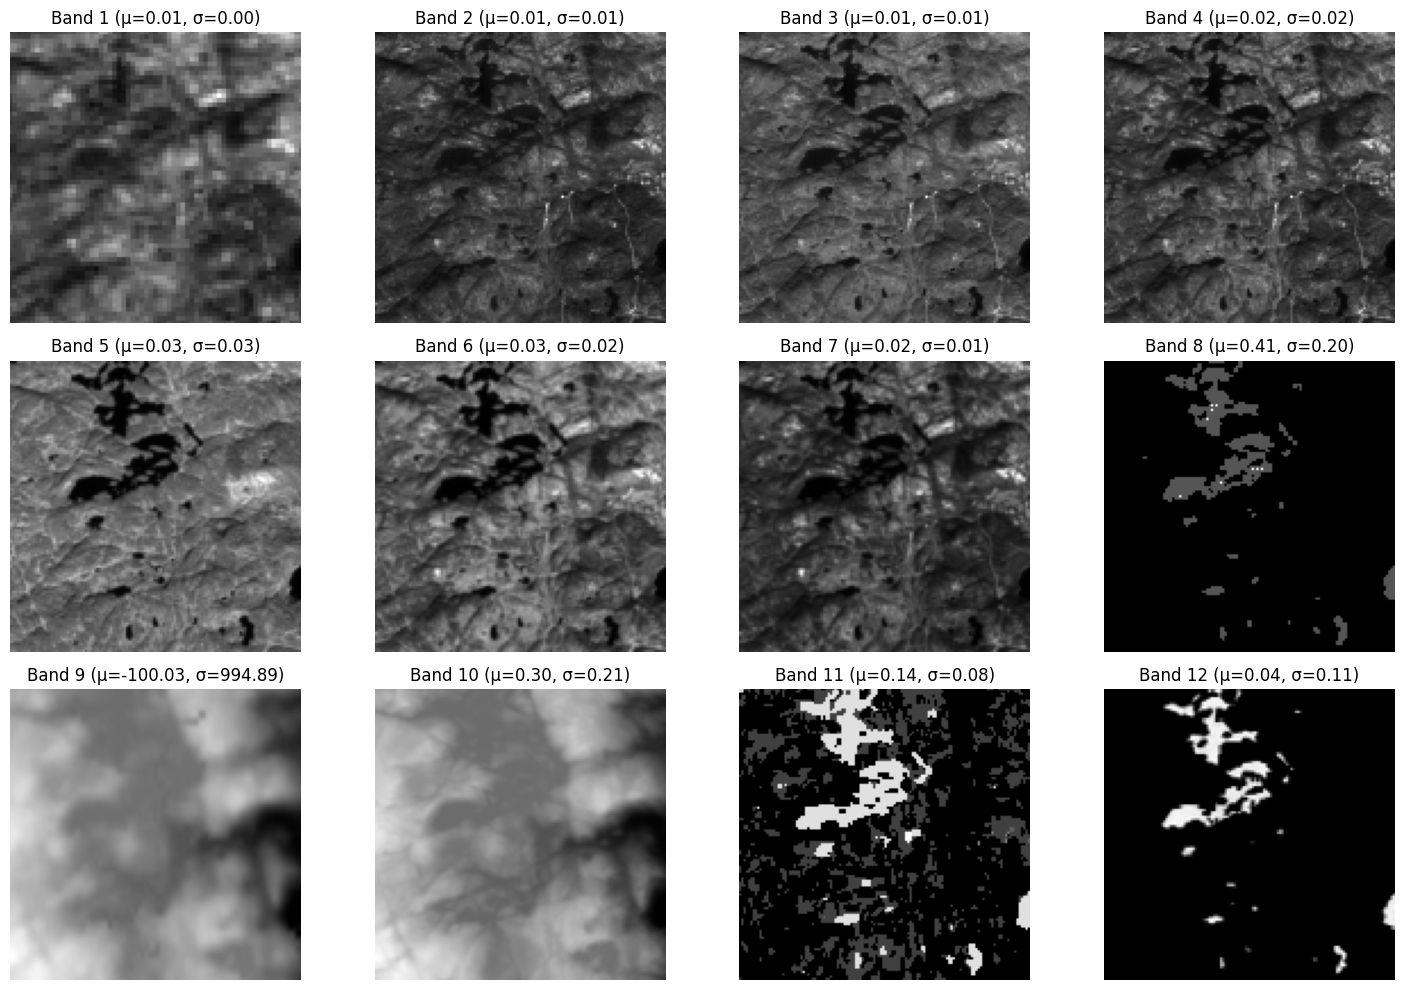

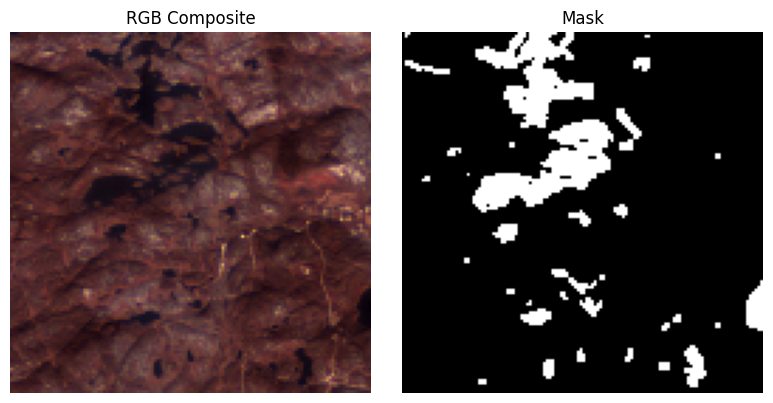

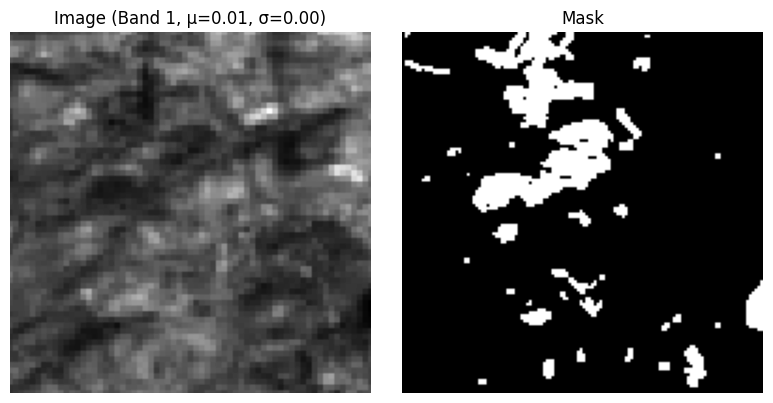

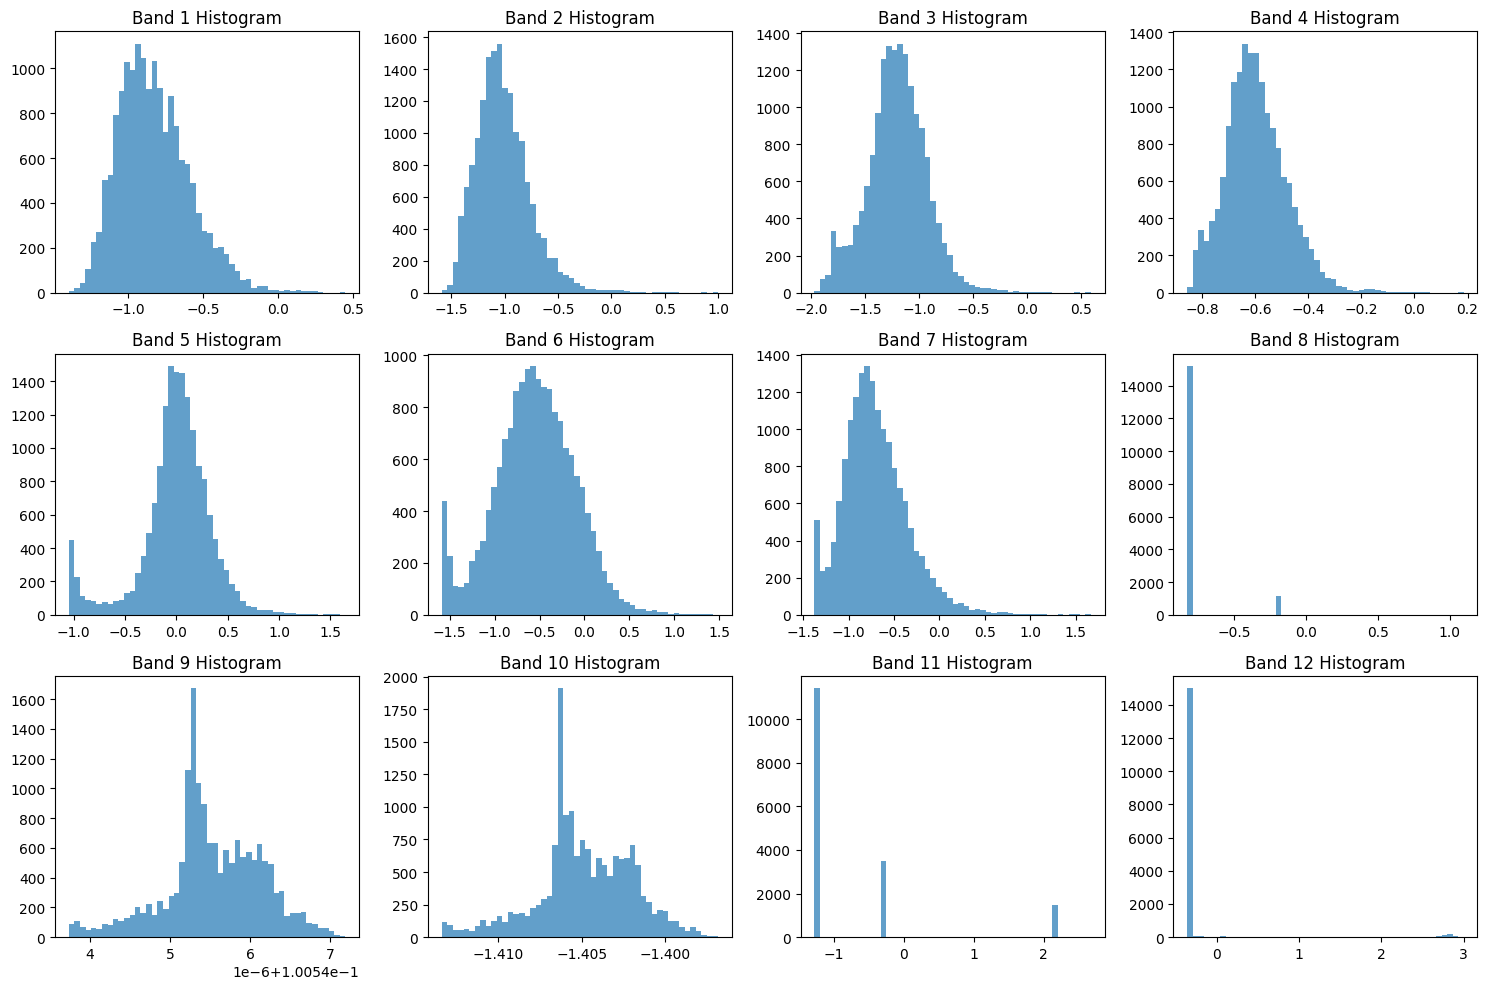

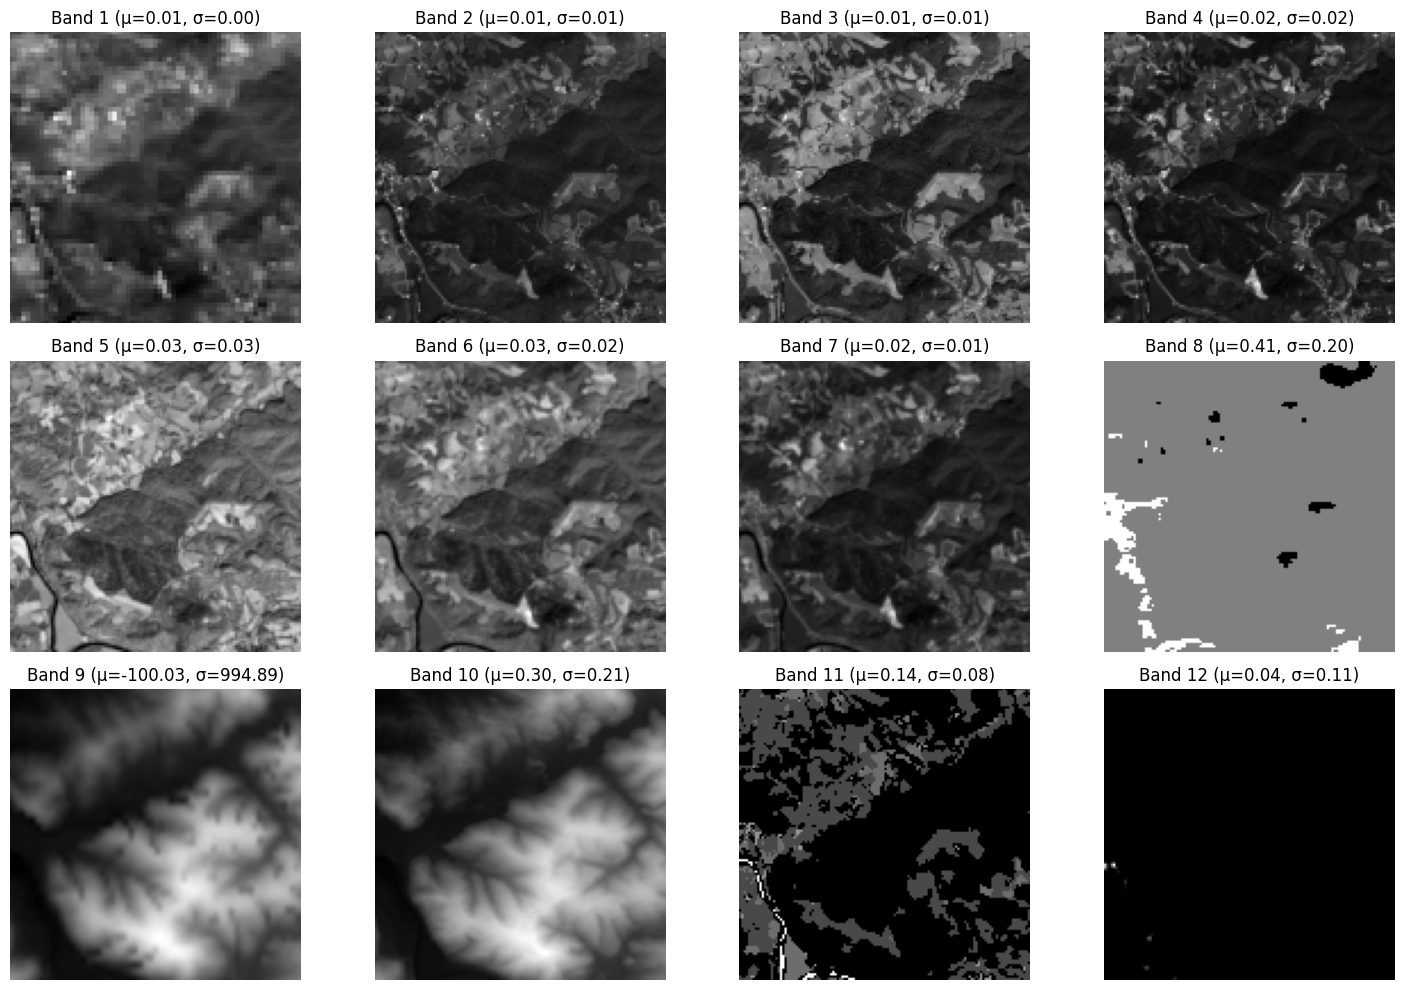

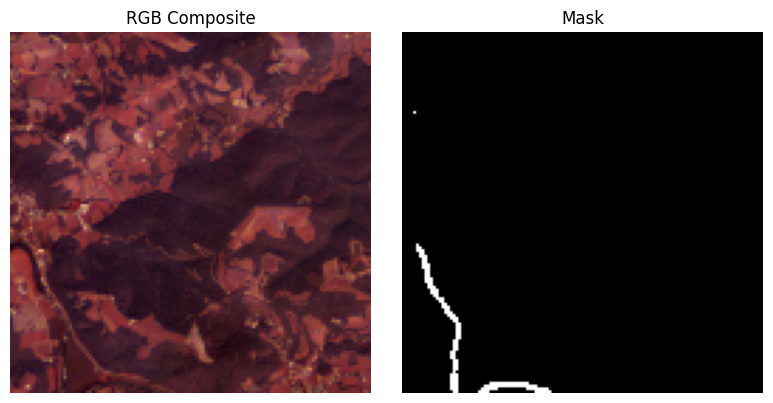

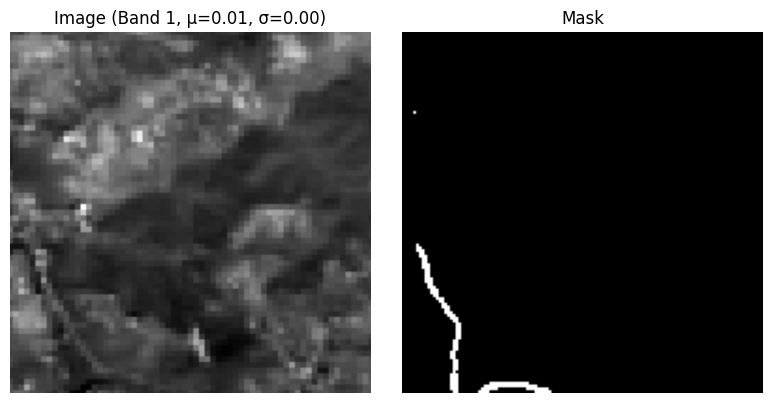

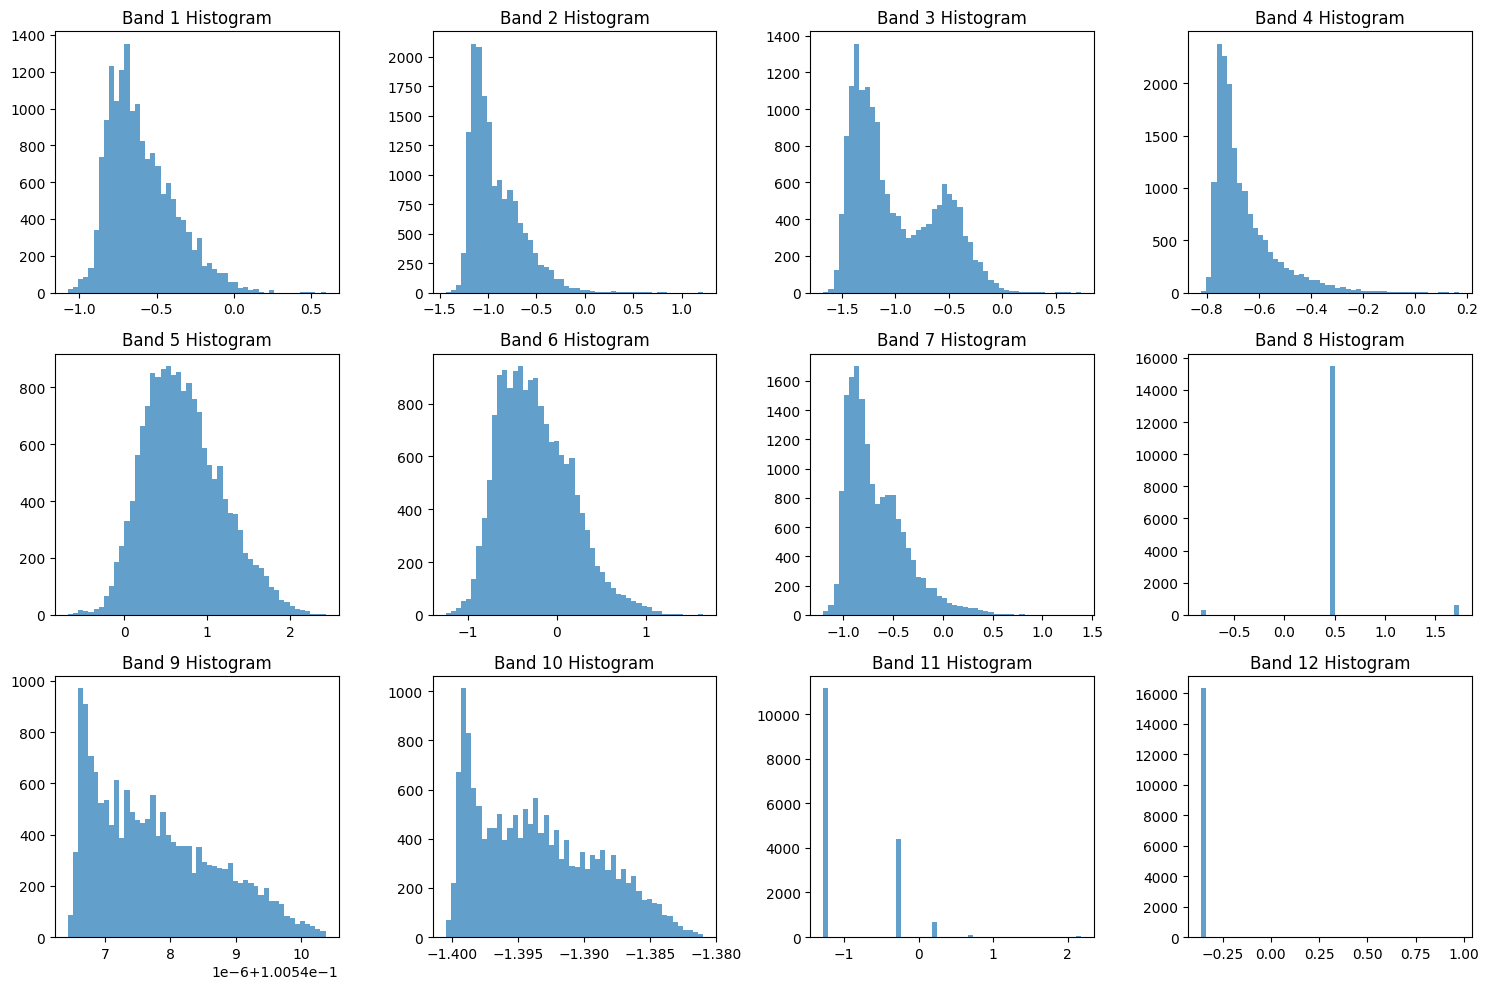

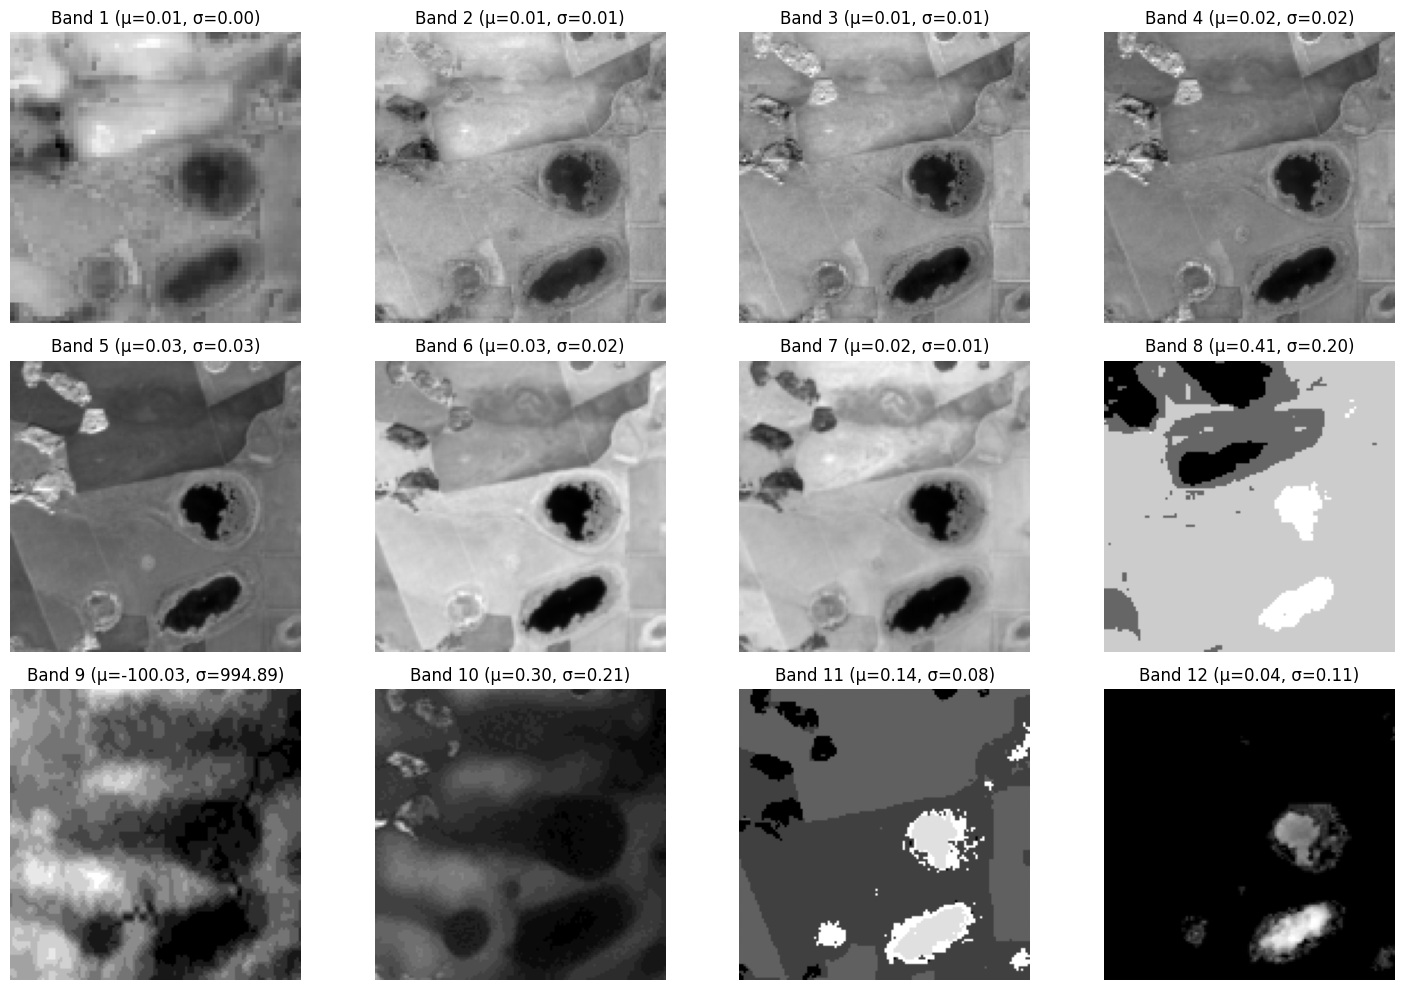

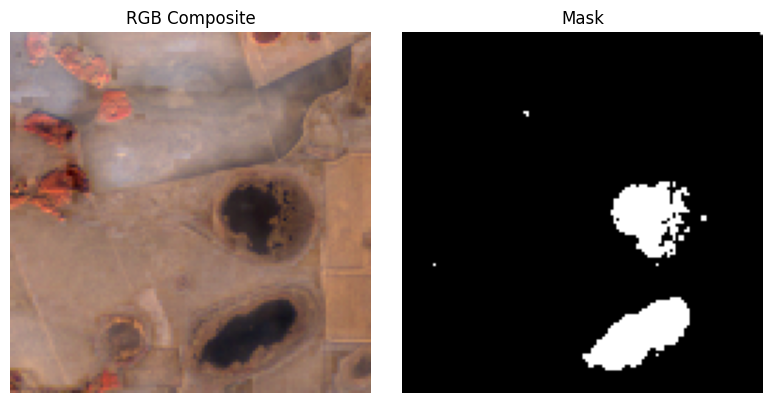

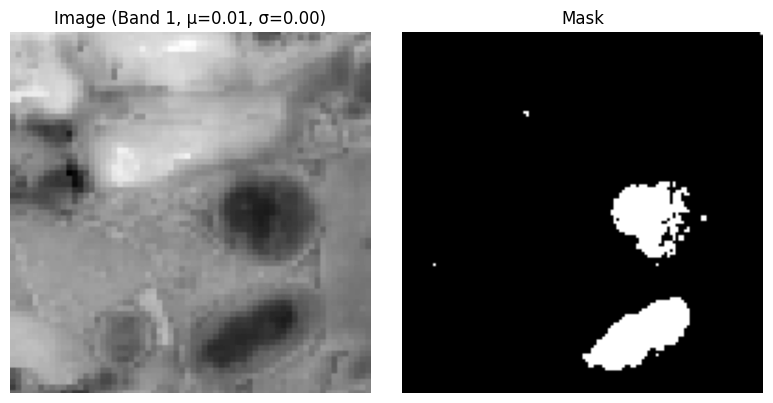

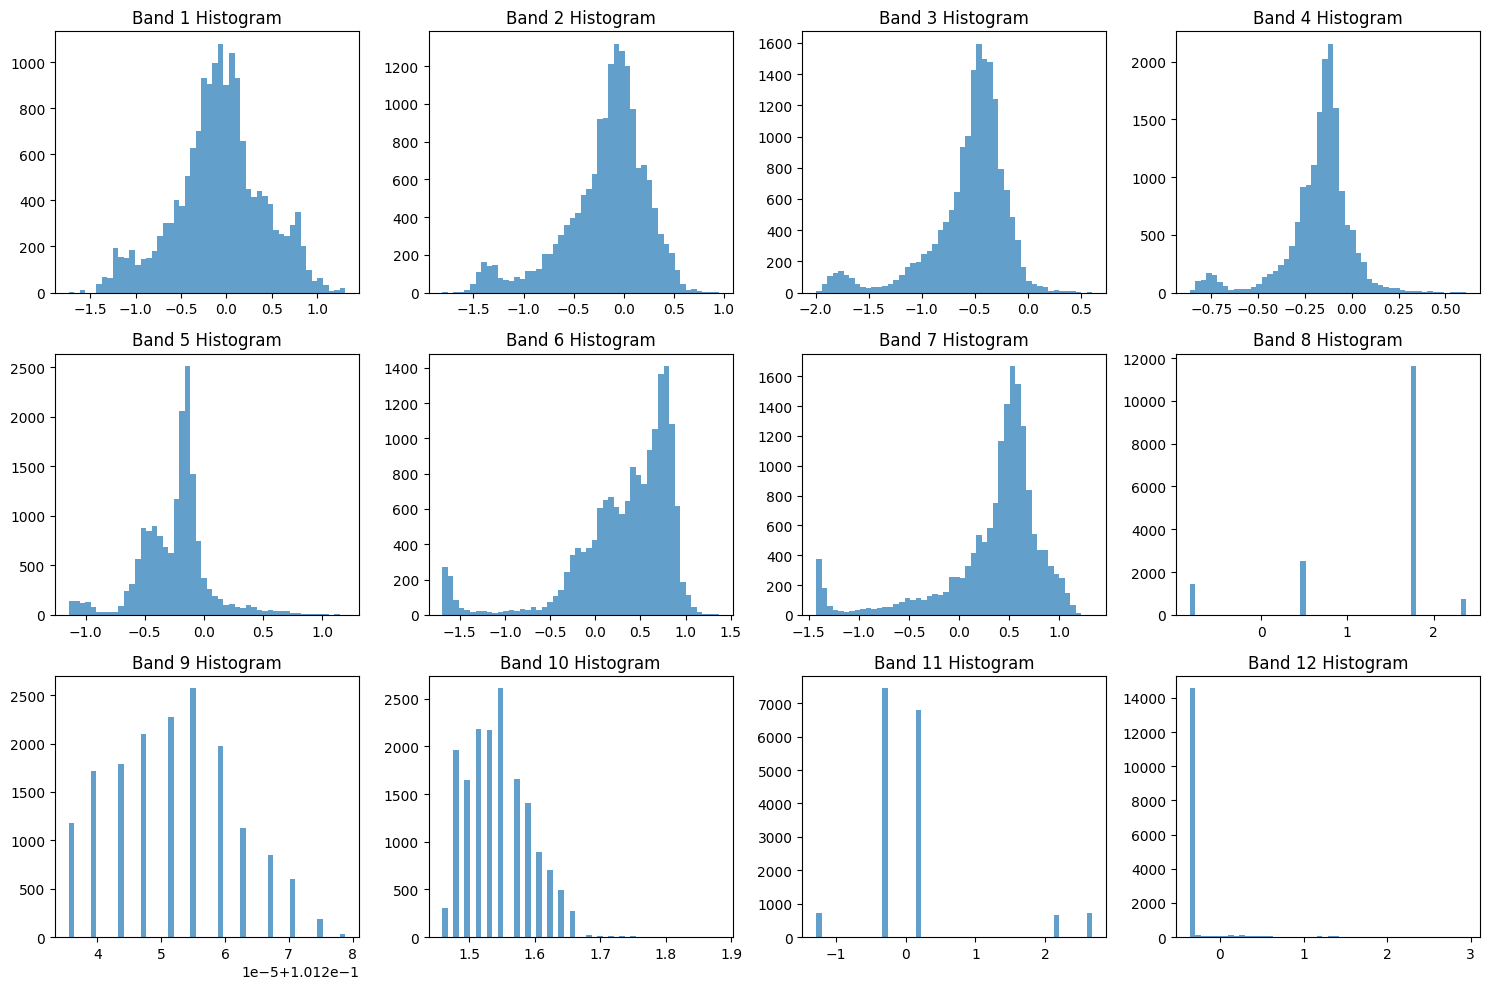

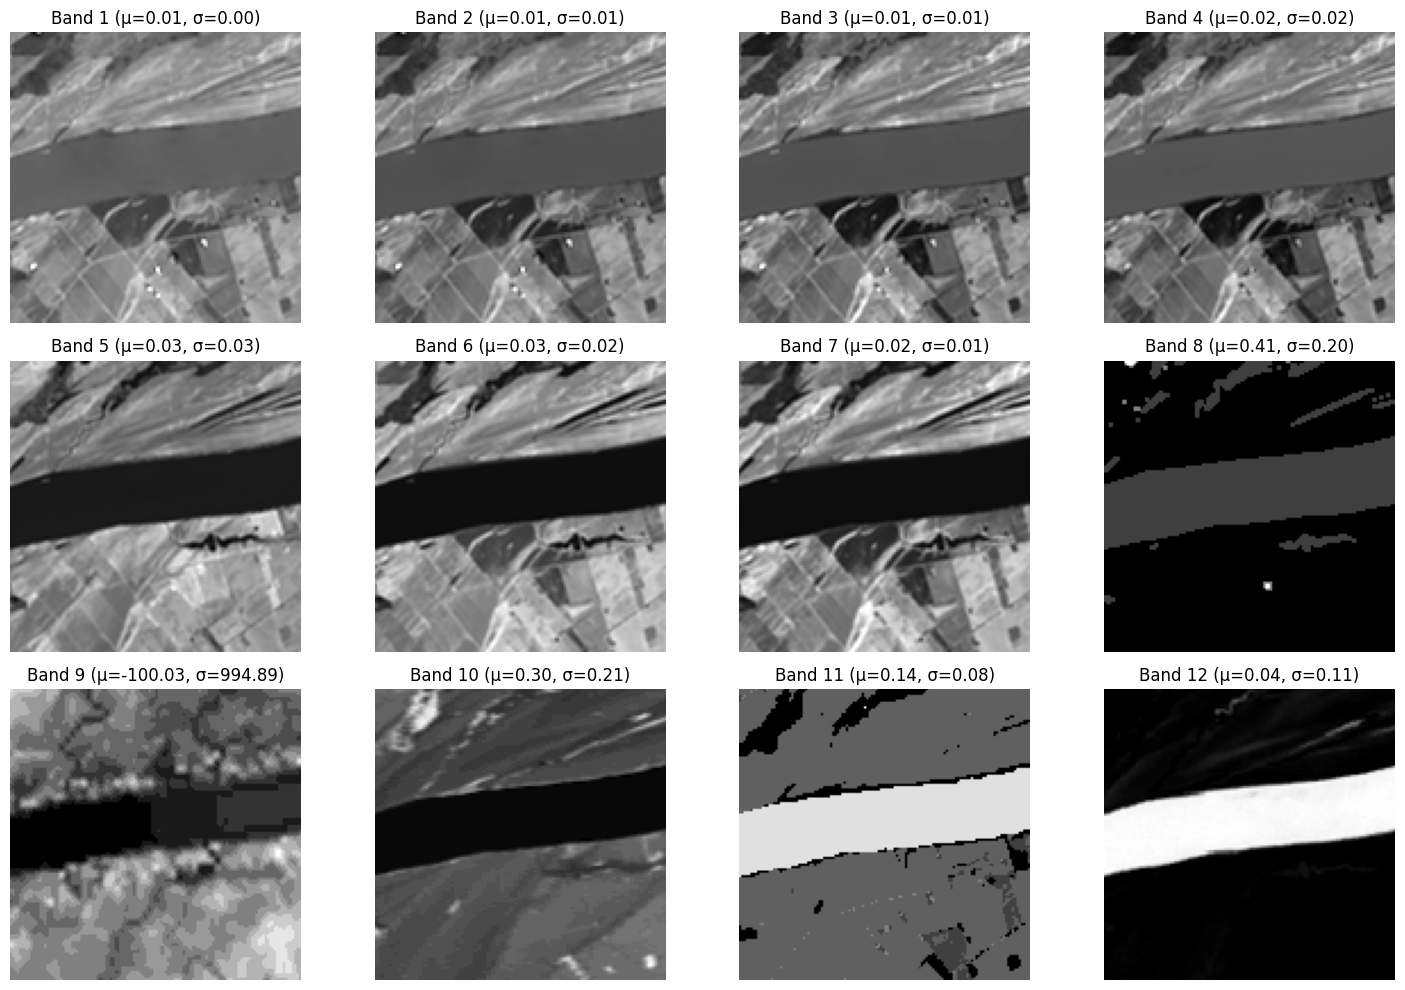

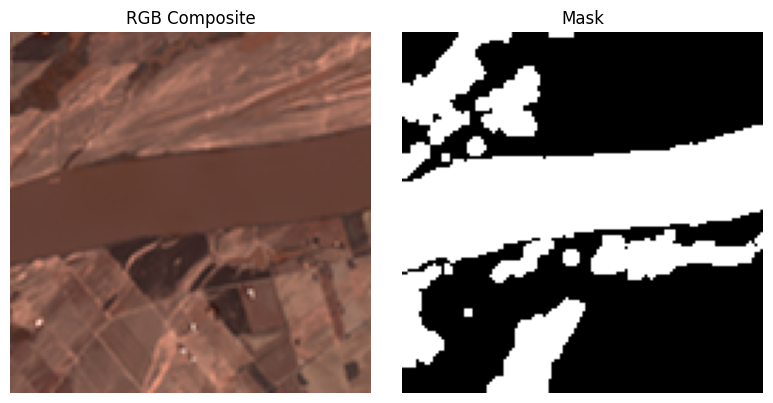

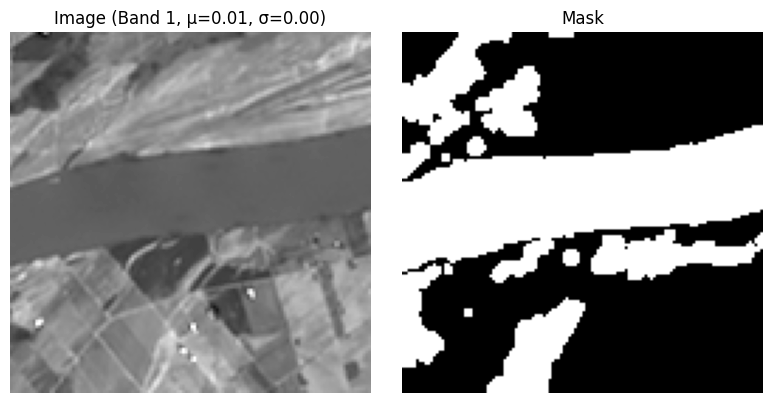

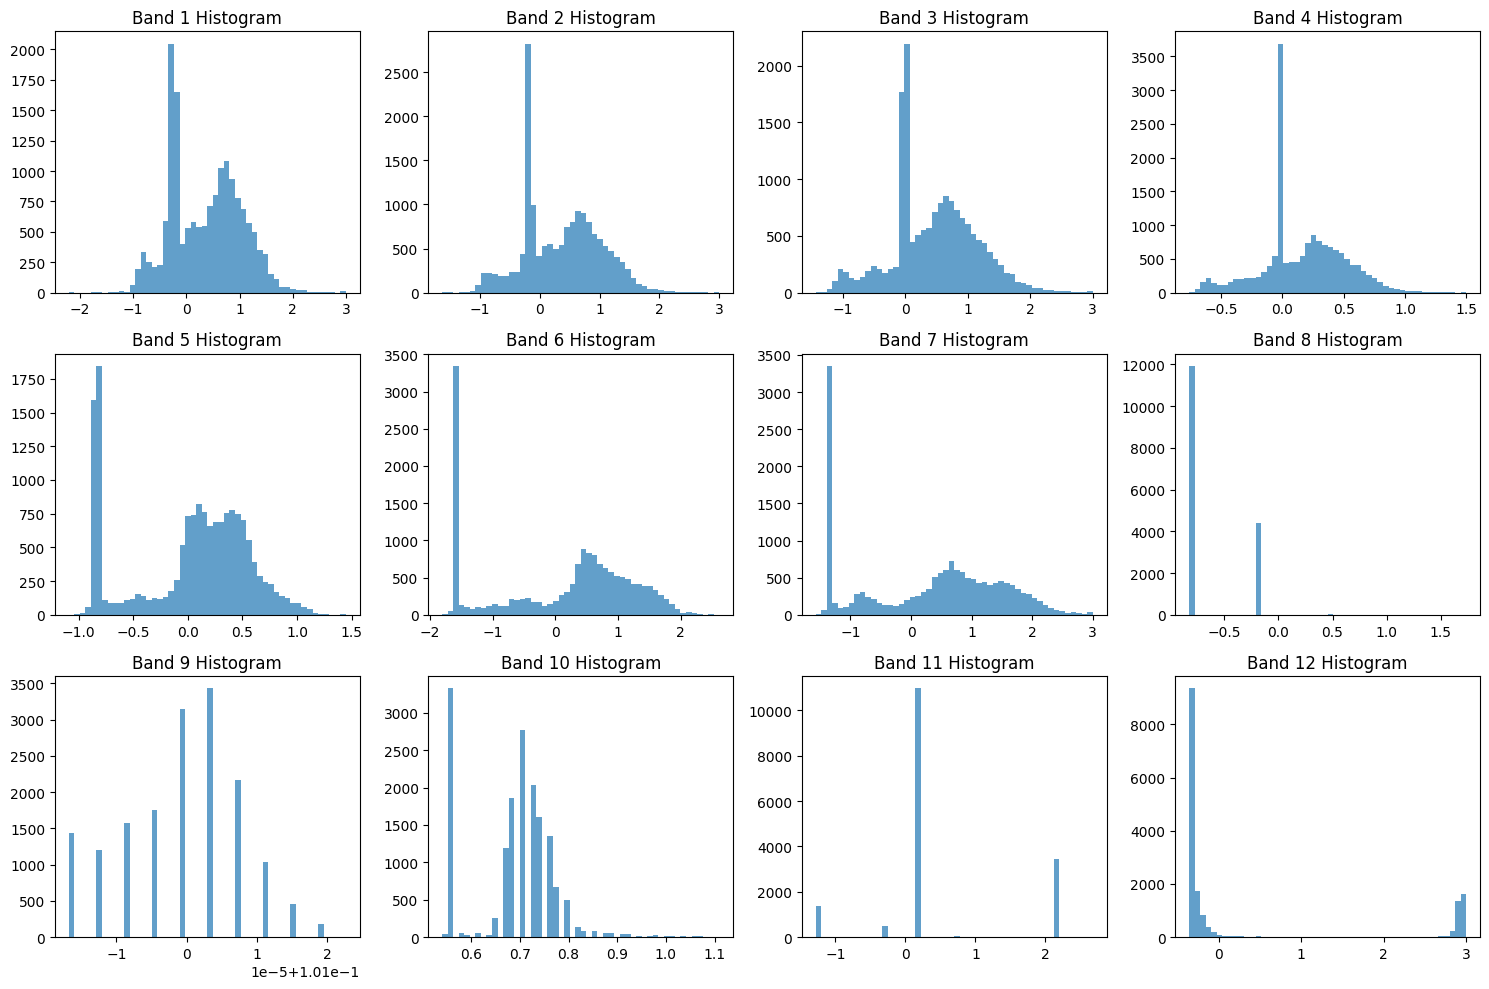

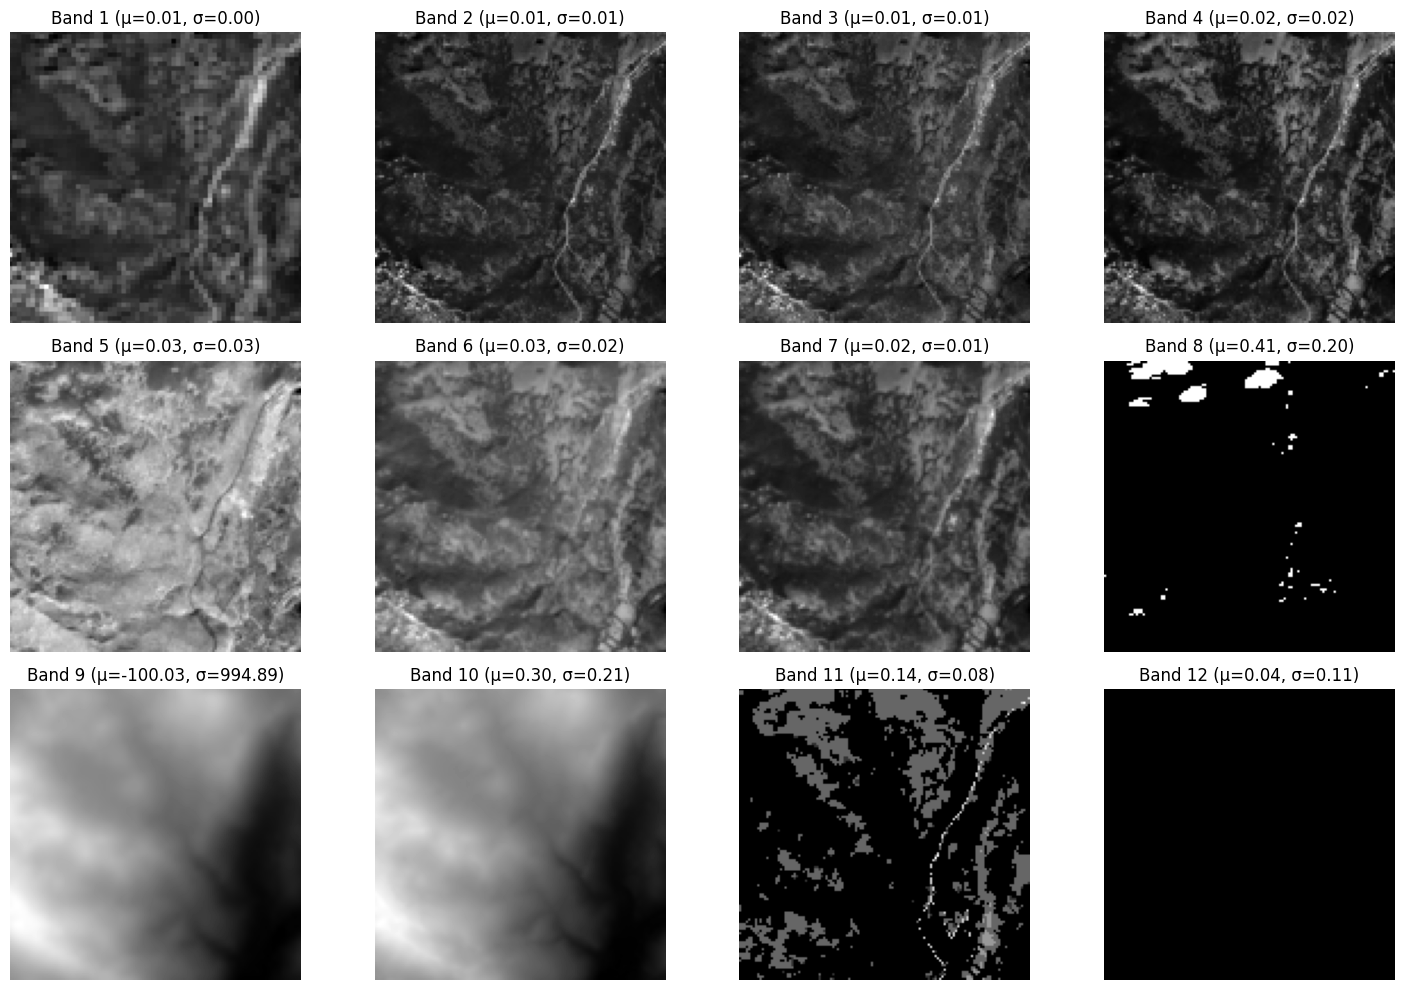

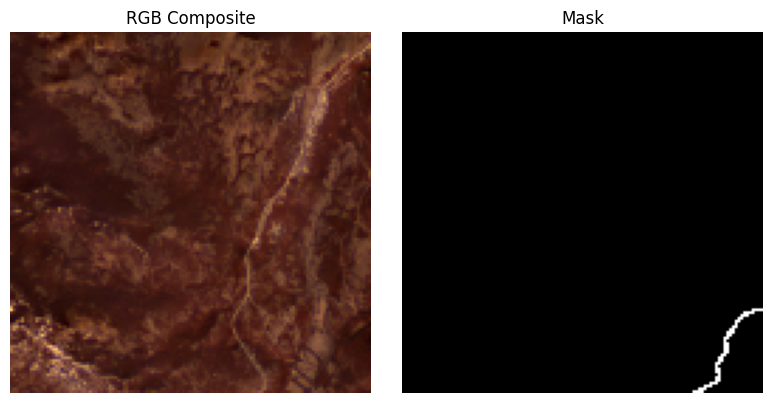

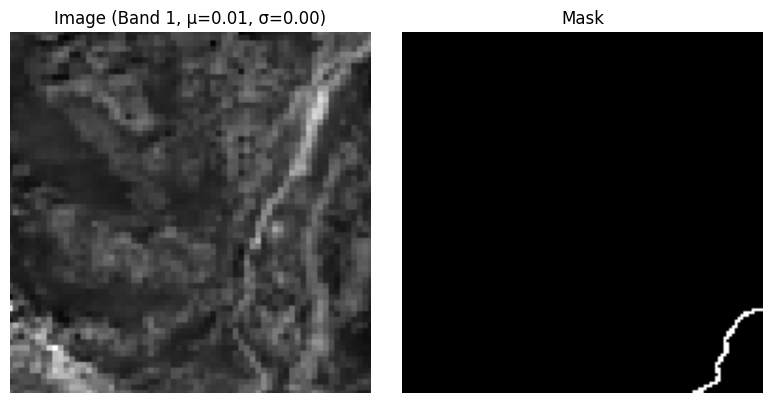

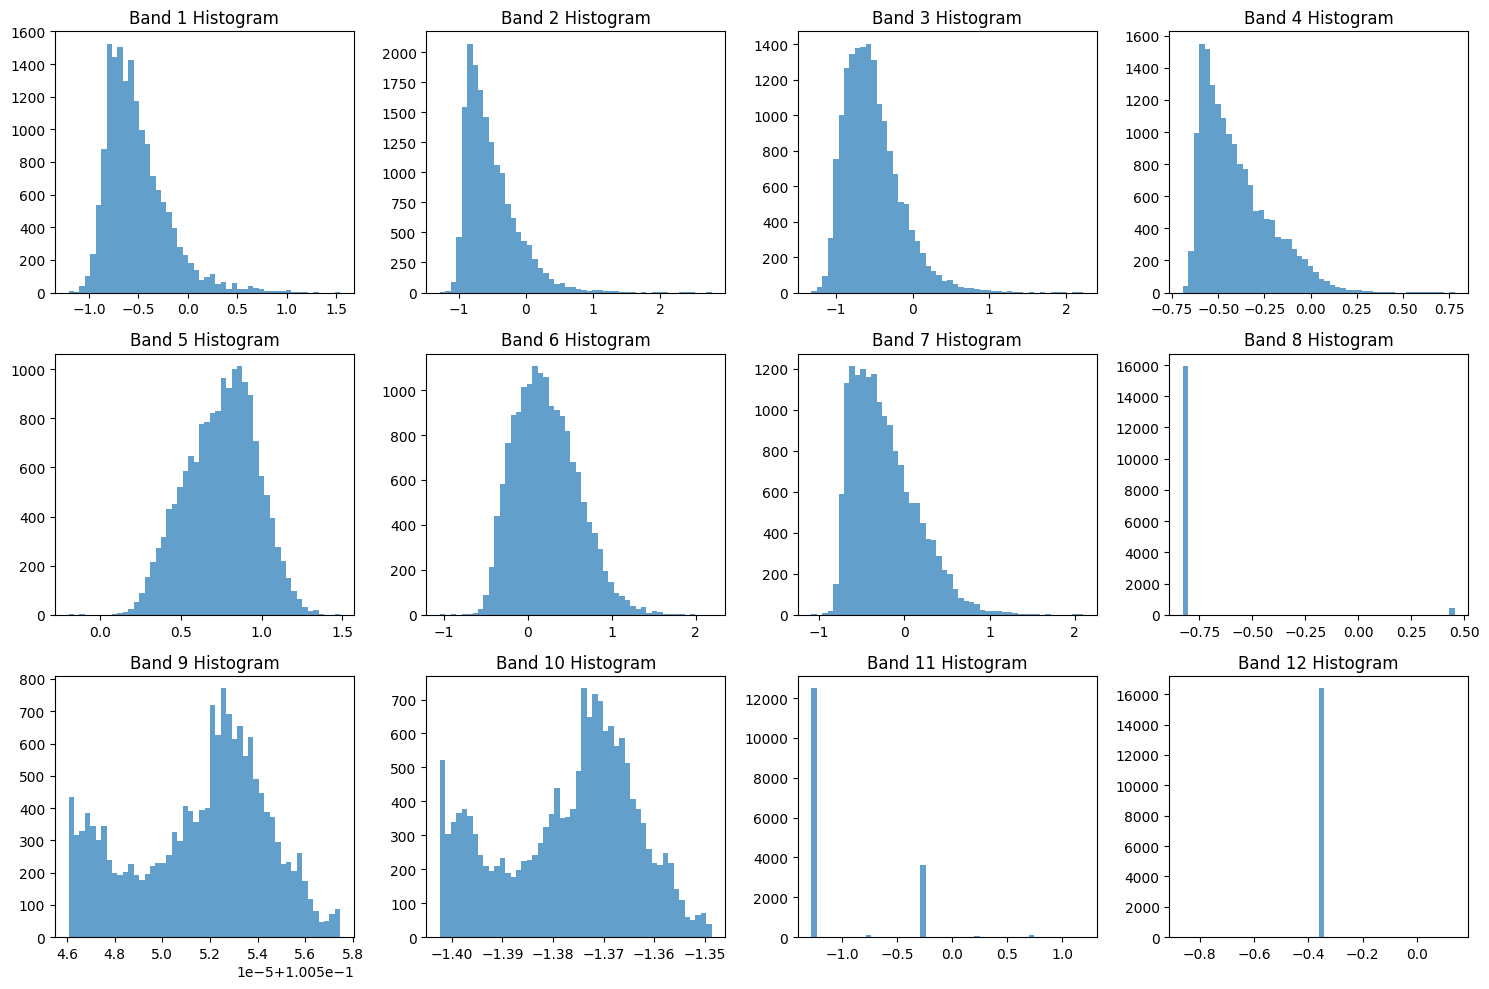

In [22]:


def display_image_and_mask(img_path, mask_path, band_idx=0, display_inline=False):
    img = read_tiff_image(img_path)
    mask = load_mask_np(mask_path)
    img_band = normalize_image_np(img, method='zscore')[:, :, band_idx]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_band, cmap='gray')
    plt.title(f"Image (Band {band_idx+1}, μ={band_means[band_idx]:.2f}, σ={band_stds[band_idx]:.2f})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'visualizations/single_band_{os.path.basename(img_path)}_{band_idx}.png')
    if display_inline:
        plt.show()
    plt.close()


def display_rgb_image_and_mask(img_path, mask_path, rgb_indices=[2, 1, 0], display_inline=False):
    img = read_tiff_image(img_path)
    mask = load_mask_np(mask_path)

    # Build RGB composite (ensure correct scaling)
    rgb = img[:, :, rgb_indices]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB Composite")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'visualizations/rgb_{os.path.basename(img_path)}.png')
    if display_inline:
        plt.show()
    plt.close()


def visualize_bands(img, save_path=None, display_inline=False):
    img_norm = normalize_image_np(img, method='zscore')
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    for i, ax in enumerate(axs.flatten()):
        if i < img_norm.shape[-1]:
            ax.imshow(img_norm[:, :, i], cmap='gray')
            ax.set_title(f'Band {i+1} (μ={band_means[i]:.2f}, σ={band_stds[i]:.2f})')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    if display_inline:
        plt.show()
    plt.close()


def plot_histograms(img, save_path=None, display_inline=False):
    img_norm = normalize_image_np(img, method='zscore')
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    for i, ax in enumerate(axs.flatten()):
        if i < img_norm.shape[-1]:
            ax.hist(img_norm[:, :, i].ravel(), bins=50, alpha=0.7)
            ax.set_title(f'Band {i+1} Histogram')
        else:
            ax.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    if display_inline:
        plt.show()
    plt.close()


# --- Run visualization on first few pairs ---
os.makedirs('visualizations', exist_ok=True)
for img_p, mask_p in pairs[:5]:
    img = read_tiff_image(img_p)
    visualize_bands(img, f'visualizations/bands_{os.path.basename(img_p)}.png', display_inline=True)
    display_rgb_image_and_mask(img_p, mask_p, display_inline=True)
    display_image_and_mask(img_p, mask_p, band_idx=0, display_inline=True)
    plot_histograms(img, f'visualizations/hist_{os.path.basename(img_p)}.png', display_inline=True)


# Metrics and loss 

In [18]:
def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3]) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return tf.reduce_mean(iou)

def precision_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    fp = tf.reduce_sum(y_pred, axis=[1,2,3]) - tp
    prec = (tp + 1e-6) / (tp + fp + 1e-6)
    return tf.reduce_mean(prec)

def recall_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    fn = tf.reduce_sum(y_true, axis=[1,2,3]) - tp
    rec = (tp + 1e-6) / (tp + fn + 1e-6)
    return tf.reduce_mean(rec)

def f1_metric(y_true, y_pred, threshold=0.5):
    p = precision_metric(y_true, y_pred, threshold)
    r = recall_metric(y_true, y_pred, threshold)
    return 2 * (p * r) / (p + r + 1e-6)

def accuracy_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32), axis=[1,2,3])
    total = tf.cast(tf.size(y_true[0]), tf.float32)
    return tf.reduce_mean(correct / total)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, (tf.shape(y_true)[0], -1))
    y_pred_f = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1))
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)
    denom = tf.reduce_sum(y_true_f + y_pred_f, axis=1)
    dice = (2. * intersection + smooth) / (denom + smooth)
    return 1.0 - tf.reduce_mean(dice)

bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def combined_loss(y_true, y_pred):
    bce = bce_loss_fn(y_true, y_pred)
    d = dice_loss(y_true, y_pred)
    l2_reg = tf.reduce_mean(tf.square(y_pred)) * 1e-4
    return 0.15 * bce + 0.85 * d + l2_reg

# Model 

In [19]:
def conv_block_residual(x, filters, dropout=0.0):
    shortcut = x
    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x

def resnet_unet_12band(input_shape=(128,128,12), dropout=0.25):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    s1 = conv_block_residual(x, 64, dropout)
    p1 = layers.MaxPooling2D(2)(s1)

    s2 = conv_block_residual(p1, 128, dropout)
    p2 = layers.MaxPooling2D(2)(s2)

    s3 = conv_block_residual(p2, 256, dropout)
    p3 = layers.MaxPooling2D(2)(s3)

    s4 = conv_block_residual(p3, 512, dropout)
    p4 = layers.MaxPooling2D(2)(s4)

    b = conv_block_residual(p4, 1024, dropout)

    u4 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(b)
    u4 = layers.Concatenate()([u4, s4])
    c5 = conv_block_residual(u4, 512, dropout)

    u3 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
    u3 = layers.Concatenate()([u3, s3])
    c6 = conv_block_residual(u3, 256, dropout)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    u2 = layers.Concatenate()([u2, s2])
    c7 = conv_block_residual(u2, 128, dropout)

    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
    u1 = layers.Concatenate()([u1, s1])
    c8 = conv_block_residual(u1, 64, dropout)

    c9 = conv_block_residual(c8, 32, dropout)

    edge_features = layers.Conv2D(1, 3, padding='same', activation='relu', kernel_initializer='he_normal')(c9)
    main_output = layers.Conv2D(1, 1, activation=None, kernel_initializer='he_normal')(c9)

    outputs = layers.Add()([main_output, 0.5 * edge_features])
    outputs = layers.Activation('sigmoid')(outputs)

    model = models.Model(inputs, outputs)
    return model

In [20]:
model_12band = resnet_unet_12band(input_shape=(128,128,12), dropout=0.25)
model_12band.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_3[0][0]   

 Total params: 32,535,138 (124.11 MB)

 Trainable params: 32,517,282 (124.04 MB)

 Non-trainable params: 17,856 (69.75 KB)

# Compile

In [21]:
model_12band.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combined_loss,
    metrics=[iou_metric, f1_metric, precision_metric, recall_metric, accuracy_metric]
)

# callbacks

In [37]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
]

# Train

In [38]:
EPOCHS = 80
history = model_12band.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy_metric: 0.9112 - f1_metric: 0.7289 - iou_metric: 0.5904 - loss: 0.3855 - precision_metric: 0.7398 - recall_metric: 0.7301 - val_accuracy_metric: 0.9310 - val_f1_metric: 0.6068 - val_iou_metric: 0.4807 - val_loss: 0.5294 - val_precision_metric: 0.9206 - val_recall_metric: 0.5254 - learning_rate: 2.5000e-05
Epoch 2/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy_metric: 0.8966 - f1_metric: 0.7224 - iou_metric: 0.5559 - loss: 0.3855 - precision_metric: 0.7141 - recall_metric: 0.7512 - val_accuracy_metric: 0.9293 - val_f1_metric: 0.5936 - val_iou_metric: 0.4534 - val_loss: 0.5410 - val_precision_metric: 0.9114 - val_recall_metric: 0.5082 - learning_rate: 2.5000e-05
Epoch 3/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy_metric: 0.8958 - f1_metric: 0.7383 - iou_metric: 0.5708 - loss: 0.4005 - precision_metric: 0.7504 - recall_metric: 0.7407 - val_accuracy_metric: 0.9305 - val_f1_metric: 0.6065 - val_iou_metric: 0.4

# Evaluation 

In [39]:
results = model_12band.evaluate(test_ds, return_dict=True)
print("Test metrics:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy_metric: 0.9192 - f1_metric: 0.7895 - iou_metric: 0.6567 - loss: 0.5238 - precision_metric: 0.9621 - recall_metric: 0.6736
Test metrics:
accuracy_metric: 0.9222
f1_metric: 0.8051
iou_metric: 0.6802
loss: 0.4777
precision_metric: 0.9634
recall_metric: 0.6950


# visualization The model prediction 

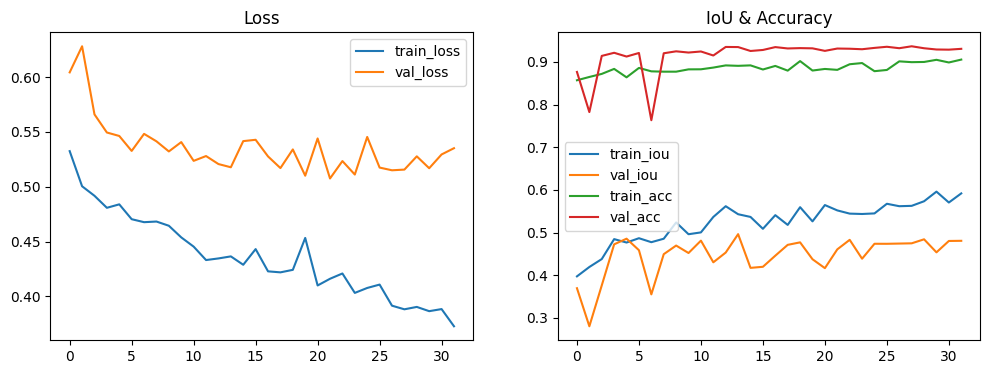

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(history.history['loss'], label='train_loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].set_title('Loss')
axs[0].legend()

axs[1].plot(history.history['iou_metric'], label='train_iou')
axs[1].plot(history.history['val_iou_metric'], label='val_iou')
axs[1].plot(history.history['accuracy_metric'], label='train_acc')
axs[1].plot(history.history['val_accuracy_metric'], label='val_acc')
axs[1].set_title('IoU & Accuracy')
axs[1].legend()

plt.savefig('visualizations/training_curves.png')
plt.show()
plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


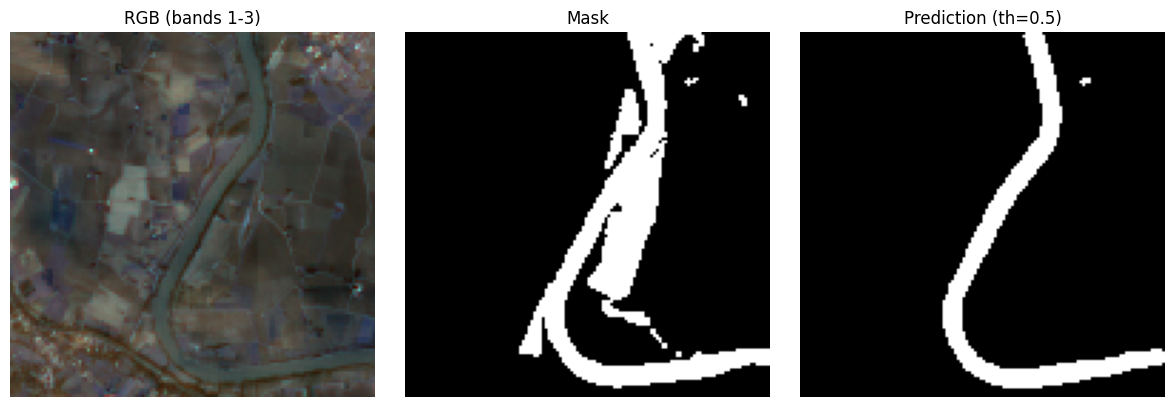

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


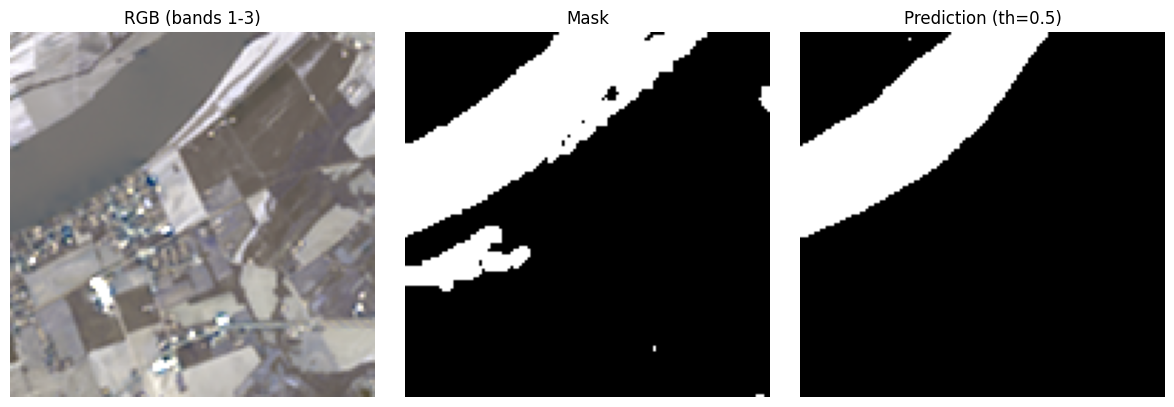

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


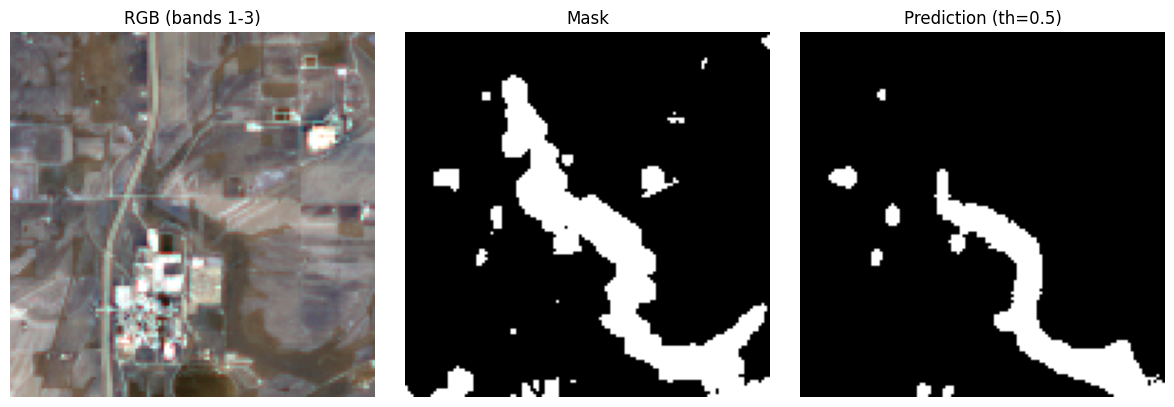

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


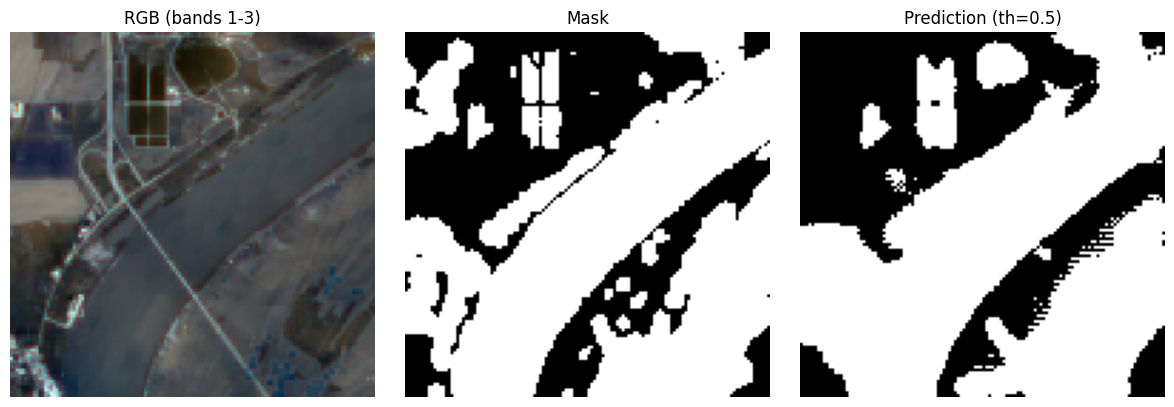

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


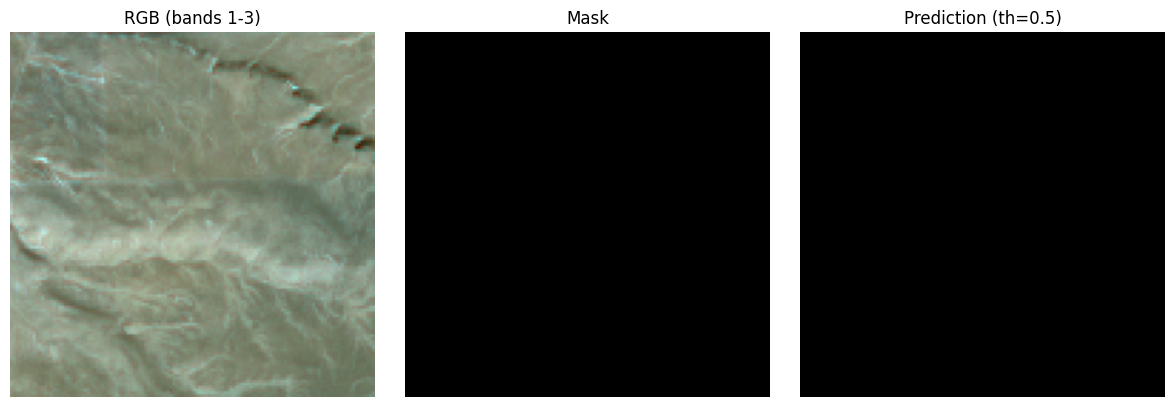

In [30]:
def display_sample(img_np, mask_np, pred_np=None, idx=0):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    rgb = img_np[:, :, :3]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
    plt.imshow(rgb)
    plt.title('RGB (bands 1-3)')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(mask_np.squeeze(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    if pred_np is not None:
        plt.subplot(1,3,3)
        plt.imshow((pred_np.squeeze() > 0.5).astype(np.float32), cmap='gray')
        plt.title('Prediction (th=0.5)')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

for i, (img_p, mask_p) in enumerate(test_pairs[:5]):
    img = normalize_image_np(read_tiff_image(img_p), method='zscore')
    mask = load_mask_np(mask_p)
    pred = model_12band.predict(img[np.newaxis, ...])[0]
    display_sample(img, mask, pred)